In [1]:
import os
import site
import sqlite3
import sys
from time import sleep

import logzero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm
from yaml import dump, load, safe_load

In [2]:
log_path = "logs/"
log_file = "tseries1.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [3]:
sys.path.append("../../sql")
import queries

In [4]:
configs = None
try:
    with open("../source/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_locations"]["db_path"]
city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "-" + state + ".db"
db_table1 = configs["file_locations"]["db_table1"]
db_table2 = configs["file_locations"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [5]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()
get_nsr_rows = queries.select_nsr_rows
year1 = "2020"
year2 = "2015"
zipcode = "74145"

In [7]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['73108', '73109', '73110', '73115', '73119', '73129', '73130', '73135', '73139', '73145', '73149', '73150', '73159', '73160', '73165']


In [13]:
select_nsr_rows = f"""
SELECT date_time, year, zipcode, DHI, DNI, GHI, Temperature from nsrdb
where zipcode = "73145"
and year in (2020, 2016, 2011);
"""

In [14]:
print(select_nsr_rows)


SELECT date_time, year, zipcode, DHI, DNI, GHI, Temperature from nsrdb
where zipcode = "73145"
and year in (2020, 2016, 2011);



In [62]:
df = pd.read_sql(
    # get_nsr_rows,
    select_nsr_rows,
    conn,
    # params={"zipcode": zipcode, "year1": year1, "year2": year2},
    index_col="date_time",
    parse_dates=["date_time"],
)

In [63]:
# drop_eval = (df_daily[df_daily["date_time"] > pd.to_datetime("2015-12-31")].index).intersection(df_daily[df_daily["date_time"] < pd.to_datetime("2020-01-01")].index)
# df_daily = df_daily.drop(drop_eval).set_index("date_time")

df_2020 = df[df['year']==2020].resample("D").sum().reset_index(drop=False)
df_2020['year']=2020
df_2020['Temperature'] = df_2020['Temperature']/24
# if len(df_2020) == 366:
#     df_2020= df_2020.drop(df_2020[df_2020['date_time']==pd.to_datetime("2020-02-29")].index)
df_2020.set_index("date_time", inplace=True)

df_2016 = df[df['year']==2016].resample("D").sum().reset_index(drop=False)
df_2016['year']=2016
df_2016['Temperature'] = df_2016['Temperature']/24
# if len(df_2016) == 366:
#     df_2016= df_2016.drop(df_2016[df_2016['date_time']==pd.to_datetime("2016-02-29")].index)
df_2016.set_index("date_time", inplace=True)

df_2011 = df[df['year']==2011].resample("D").sum().reset_index(drop=False)
df_2011['year']=2011
df_2011['Temperature'] = df_2011['Temperature']/24
df_2011.set_index("date_time", inplace=True)

In [64]:
df_2020

,year,DHI,DNI,GHI,Temperature
date_time,,,,,
2020-01-01,2020,795.0,5096.0,2873.0,5.508333
2020-01-02,2020,1248.0,2577.0,2287.0,7.600000
2020-01-03,2020,713.0,4789.0,2669.0,5.058333
2020-01-04,2020,445.0,7620.0,3370.0,3.570833
2020-01-05,2020,459.0,7674.0,3430.0,5.583333
...,...,...,...,...,...
2020-12-27,2020,745.0,6159.0,2978.0,7.754167
2020-12-28,2020,1181.0,1464.0,1809.0,4.495833
2020-12-29,2020,347.0,494.0,420.0,10.158333


In [65]:
# decomp = seasonal_decompose(df_daily["DNI"], model="additive"), period=2, extrapolate_trend=2)
decomp_2020 = seasonal_decompose(df_2020["DNI"], model="additive")
decomp_2016 = seasonal_decompose(df_2016["DNI"], model="additive")
decomp_2011 = seasonal_decompose(df_2011["DNI"], model="additive")

In [66]:
    plt.rcParams["figure.figsize"] = 30, 25
    plt.rcParams["ytick.labelsize"] = 11
    plt.rcParams["axes.labelsize"] = 14
    plt.rcParams["axes.labelpad"] = 12
    plt.rcParams["axes.xmargin"] = 0.01
    plt.rcParams["axes.ymargin"] = 0.01

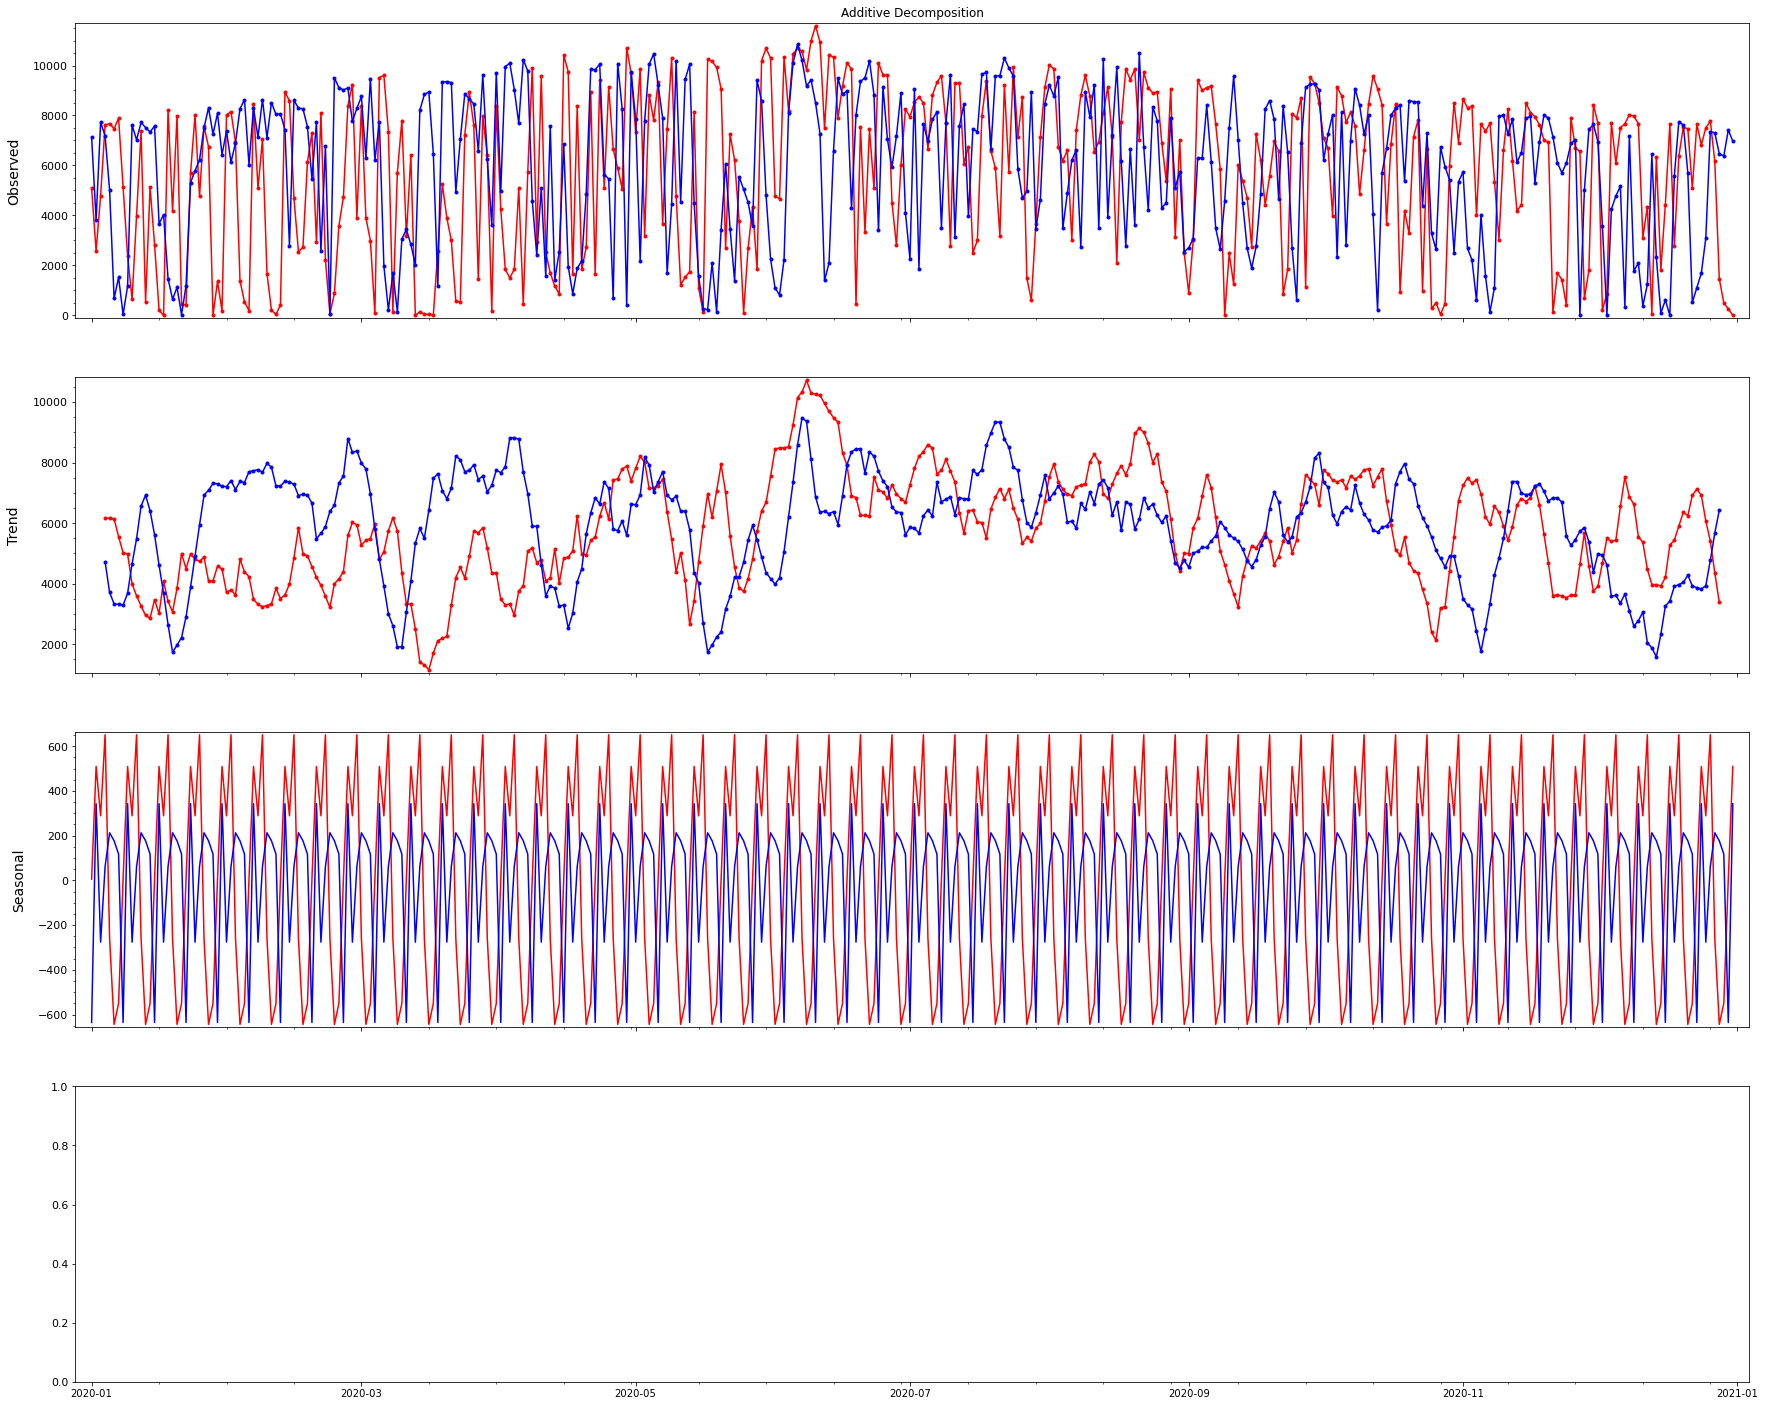

In [67]:
fig, ax = plt.subplots(4, sharex=True)
ax[0].set_title("Additive Decomposition")
ax[0].minorticks_on()
# ax[0].plot(decomp.observed.index, decomp.observed)
ax[0].plot(decomp_2020.observed.index, decomp_2020.observed, '.-', color='red')
ax[0].plot(decomp_2020.observed.index, decomp_2016.observed, '.-', color='blue')
ax[0].set(ylabel="Observed")

ax[1].plot(decomp_2020.trend.index, decomp_2020.trend, '.-', color='red')
ax[1].plot(decomp_2020.trend.index, decomp_2016.trend, '.-', color='blue')
ax[1].minorticks_on()
ax[1].set(ylabel="Trend")

ax[2].plot(decomp_2020.seasonal.index, decomp_2020.seasonal, color='red')
ax[2].plot(decomp_2020.seasonal.index, decomp_2016.seasonal, color='blue')
ax[2].minorticks_on()
ax[2].set(ylabel="Seasonal")

# ax[3].plot(decomp.resid.index, decomp.resid, "o")
# ax[3].hlines(0, xmin=min(decomp.resid.index), xmax=max(decomp.resid.index), colors="black")
# ax[3].minorticks_on()
# ax[3].set(xlabel="created_at", ylabel="Residual")

plt.show()